# Notebook evaluating metrics for particular node/edge configuration

In [ ]:
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [6]:
## Define variables
# Label imports
buildingFile = "./data/beirutBuildingFootprints.geojson" # OSM data
assessmentFile = "./data/geopalData.csv" # GeoPal data
bourjData = "./data/bourjHammoud.csv" # GeoPal Extra
manualData = "./data/manualDamageClasses.csv" # GeoPal manual data
crs = 'epsg:4326' # Coordinate system
cn = 'decision' # Column for classes
splitString = True # Only use first word in class column
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Data imports
dataTypes = ['ifg',['R','G','B']]
ifgPreFile = "./data/beirutPrePreExplosionIfg.tif" # SNAP output 1
ifgPostFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output 2
ifgBoth = False # If false, only uses prePost rather than difference between two
hrPreFile = "data/highRes/20JUL31083035-S2AS-MEDIA-Beirut-JUL31-small.TIF" # High Res image Pre
hrPostFile = "data/highRes/20AUG05084637-S2AS-MEDIA-Beirut-AUG05-25km.TIF" # High resolution img Post

# Map filtering of location
lat, lon, zoom = 33.893, 35.512, 14 # Map properties
stdTest = False # Use standard area for Beirut testing

# Class options
nClasses = 2 # Enforce number of classes (False -> # classes in labels)
classNames = ['Undamaged','Damaged'] # Enforce names of classes (False -> cl0, cl1,...)
classAssign = [['GREEN'],['YELLOW','RED']] # Enforce class grouping (False -> Clustering is performed)
pca, pcaComps, meanCluster = False, 2, True # Clustering properties if used

# Edge creation
adjacent, geoNeighbours = False, 4 # geographical edges, n neighbours
phase, neighbours = True, [3] # Data value edges, n neighbours for each data type

In [3]:
## Import Labels and combine
# Import OSM
footprints = ip.import_OSM_fps(buildingFile)

# Import GeoPal assessments
assessments1 = ip.import_located_geopal_data(assessmentFile)
assessments2 = ip.append_geopal_data(assessments1, bourjData, 'decision - القرار_w_2048411', True)
assessments = ip.append_geopal_data(assessments2, manualData)

# Get joint geodataframe of building footprints with damage assessments
labels = hf.join_gdfs(footprints, assessments, column=cn)
if splitString: labels[cn] = labels[cn].str.split(' ').str[0]

# Display map of assessments upon which to draw Polygon for analysis
m1 = pl.create_map(lat, lon, zoom)
m1 = pl.plot_assessments(labels, m1)
m1, testPoly = pl.draw_polygon(labels, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [14]:
## Import data
# Interferometry
ifg, poly = ip.image_to_df(ifgPostFile, dataTypes[0], testPoly) # Import interferogram to dataframe
if ifgBoth: # If using both interferograms then subtract phase of second from first to get differecne
    ifgPre, _ = ip.image_to_df(ifgPreFile, dataTypes[0], testPoly)
    ifg = ifgPre-ifg
ifgGdf = hf.df_to_gdf(ifg, [dataTypes[0]],crs='epsg:4326',reIndex=True, invCoords=True)

# High-Resolution Imagery import
hrPreGdf = hr_to_gdf(hrPreFile, testPoly, "epsg:32636")
hrPostGdf = hr_to_gdf(hrPostFile, testPoly, "epsg:32636")
hrGdf = hrPostGdf - hrPreGdf
hrGdf['geometry'] = hrPreGdf['coordinates']
del(hrGdf['coordinates'])

# Merge into data
data = hrGdf

In [13]:
# High-Resolution Imagery
import rioxarray as rxr
import shapely.geometry as sg
import geopandas as gpd
import numpy as np
import pandas as pd

def hr_to_gdf(file, polygon, crs, crsObj='epsg:4326'):
    # High-Resolution Imagery import
    hr = rxr.open_rasterio(file, masked=True).squeeze()

    # Get extent in local coords
    try: newPoly = sg.Polygon([[p['lat'], p['lng']] for p in polygon.locations[0]])
    except: newPoly = sg.Polygon([[p[0],p[1]] for p in polygon.locations])
    bds = gpd.GeoSeries([newPoly], crs=crsObj).to_crs(crs).bounds.values[0]
    hrExtent= gpd.GeoSeries([sg.Polygon.from_bounds(bds[0],bds[1],bds[2],bds[3])], crs=crs)

    # Trim image to polygon

    hrClip = hr.rio.clip(hrExtent.geometry.apply(sg.mapping))
    named = hrClip.rename('img')
    xm, ym = np.meshgrid(np.array(named.coords['x']), np.array(named.coords['y']))
    mi = pd.MultiIndex.from_arrays([ym.flatten(),xm.flatten()],names=('y','x'))

    # Convert to geodataframe with lat/long
    df = pd.DataFrame(named.data.reshape(3,-1).transpose(), index=mi)
    hrGdf = hf.df_to_gdf(df,df.columns,crs=crs, reIndex=True).to_crs(crsObj)
    convert = hrGdf
    convert['coordinates']  = list(zip(convert.geometry.y, convert.geometry.x))
    convert['coordinates'] = convert['coordinates'].apply(sg.Point)
    convert = gpd.GeoDataFrame(convert, geometry='coordinates', crs = crsObj)
    del(convert['geometry'])
    return convert

In [49]:
# from scipy.spatial import cKDTree
# from shapely.geometry import Point

# # gpd1 = gpd.GeoDataFrame([['John', 1, Point(1, 1)], ['Smith', 1, Point(2, 2)],
# #                          ['Soap', 1, Point(0, 2)]],
# #                         columns=['Name', 'ID', 'geometry'])
# # gpd2 = gpd.GeoDataFrame([['Work', Point(0, 1.1)], ['Shops', Point(2.5, 2)],
# #                          ['Home', Point(1, 1.1)]],
# #                         columns=['Place', 'geometry'])

# def ckdnearest(gdA, gdB):

#     nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
#     nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
#     btree = cKDTree(nB)
#     dist, idx = btree.query(nA, k=1)
#     gdB_nearest = gdB.iloc[idx].drop(columns="geometry")
#     gdf = pd.concat(
#         [
#             gdA,
#             gdB_nearest,
#             pd.Series(dist, name='dist')
#         ], 
#         axis=1)

#     return gdf

# data = ckdnearest(hrGdf, ifgGdf)

KeyboardInterrupt: 

In [19]:
# Assign Label classes to data
defClasses, labelsUsed, dataUsed = len(labels[cn].unique()), labels.copy(), data.copy() # Default classes from labels
usedNames = labels[cn].unique() if nClasses==defClasses or nClasses is False else classNames
initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs) # Initial class value for each data pixel

if not nClasses: nClasses = defClasses # If default classes used
elif nClasses > defClasses: raise NameError('Cannot assign more classes than in original data') # If invalid input
elif nClasses < defClasses: # Perform class grouping
    if not classAssign: # Perform clustering
        # Assign labels to each pixel
        allPixels = hf.create_nodes(initial, labelsUsed[['geometry',cn]][labelsUsed.within(poly)])
        # Run PCA if set to True
        X = hf.run_PCA(dataUsed[dataTypes[0]].values.transpose(), pcaComps).components_.transpose() if pca else dataUsed[dataTypes[0]]
        # Run clustering
        kmeans, clusterClasses, initLabels = hf.run_cluster(X[allPixels[cn].dropna().index].values.reshape(-1,1), allPixels[cn].dropna(), meanCluster, nClasses)
        print('Clustered classes:{} , original classes:{}'.format(clusterClasses, initLabels))
        # Create groups of classes
        classesUsed = []
        for j in range(nClasses): classesUsed.append([initLabels[i] for i, x in enumerate(list(clusterClasses)) if x==j])
    else: 
        classesUsed = classAssign
#         used = [i in hf.flatten_list(classesUsed) for i in labelsUsed.values]
#         initial = hf.init_beliefs(dataUsed[used], classes=nClasses, columns=usedNames, crs=crs)
    # Assign labels for each pixel after clustering
    labelsUsed[cn] = hf.group_classes(labelsUsed[cn], classesUsed)

In [20]:
# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(labelsUsed, cn, poly)

# Create nodes
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses:], classNames=classNames, column = cn)

# Create edges
#values=dataTypes if phase else False
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=[dataTypes[1]] , neighbours=neighbours)

/opt/conda/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [21]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-5)

Nodes: 127090, Edges: 381270
It	Loss	Label change

0	7.04618e-01		43062

1	1.47030e-01		24635

2	1.41336e-01		18709

3	2.87972e-02		14248

4	2.84820e-02		9102

5	6.44241e-03		5152

6	5.76472e-03		2662

7	1.44647e-03		1289

8	1.17149e-03		644

9	3.20702e-04		332

10	2.38951e-04		169

11	7.04163e-05		86

12	4.89049e-05		52

13	1.53434e-05		19

14	1.00399e-05		12

15	3.32286e-06		14

Time elapsed: 541.9311330318451 seconds


/opt/conda/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


              precision    recall  f1-score   support

   Undamaged       0.00      0.00      0.00         0
     Damaged       1.00      0.96      0.98      6646

    accuracy                           0.96      6646
   macro avg       0.50      0.48      0.49      6646
weighted avg       1.00      0.96      0.98      6646



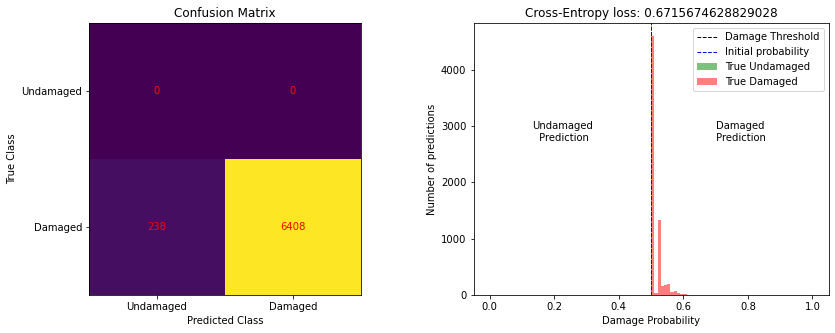

In [22]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, column=cn)

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=classNames)

fig, axs = pl.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], y_true, y_pred)

pl.show_plot()

In [23]:
# Save figure
pl.save_plot(fig, 'results/Beirut_extraData_adj{}{}_hr{}{}_cl{}_std{}'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours),str(nClasses),str(stdTest)))

KeyError: 'RED'

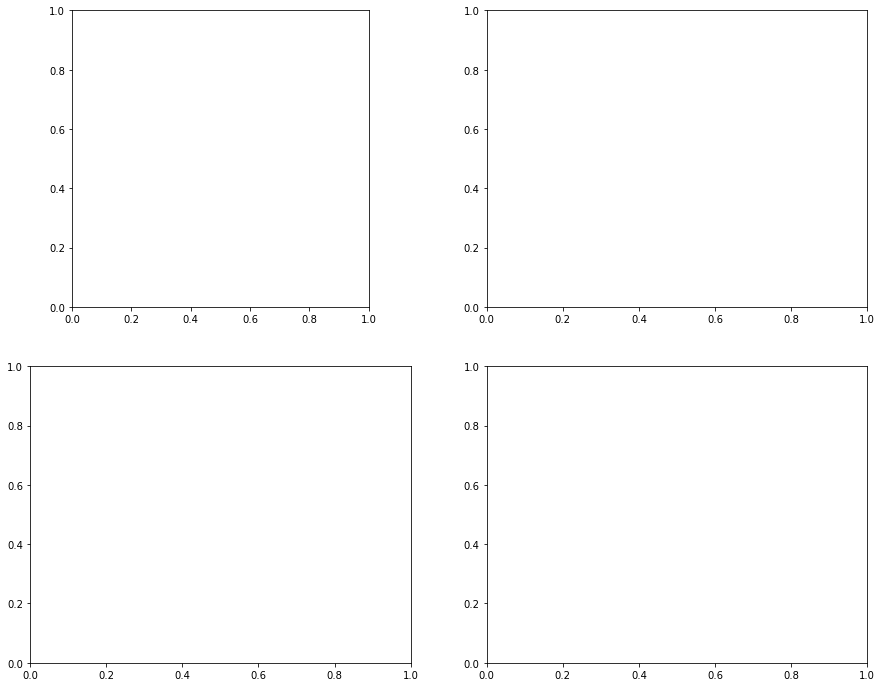

In [76]:
# Visualise spatial results
fig, axs = pl.create_subplots(2,2,figsize=[15,12])

prePlot = pl.belief_plot(nodes, axs[0,0], 'RED', normalise=False)
postPlot = pl.belief_plot(nodes, axs[0,1], beliefs, normalise=True)
assessPlt = joint.loc[joint.within(poly)].plot(ax=axs[1,0], column='decision',cmap='RdYlGn_r')
ifgPlot = (pl.cropped_ifg(ifgPreFile,testPoly)-pl.cropped_ifg(ifgPostFile,testPoly)).plot(ax=axs[1,1])
prePlot.set_title('A priori damage likelihood'), postPlot.set_title('Updated damage likelihood'), assessPlt.set_title('Damage Assessments')

pl.show_plot()